# **Named Entity Recognition (NER)**

In [ ]:
import torch
import os

CHECKPOINT_PATH = "/content/drive/MyDrive/checkpoints/train_ckpt.pt"

def save_checkpoint(epoch, model, optimizer, loss):
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss": loss
    }, CHECKPOINT_PATH)

def load_checkpoint(model, optimizer):
    if os.path.exists(CHECKPOINT_PATH):
        ckpt = torch.load(CHECKPOINT_PATH)
        model.load_state_dict(ckpt["model_state"])
        optimizer.load_state_dict(ckpt["optimizer_state"])
        print(f"Resumed from epoch {ckpt['epoch']}")
        return ckpt["epoch"] + 1
    return 0

In [ ]:
import signal

def timeout_handler(signum, frame):
    raise TimeoutError

signal.signal(signal.SIGALRM, timeout_handler)
signal.alarm(300)  # 5 minutes

try:
    val = input("Enter value:")
except TimeoutError:
    val = DEFAULT_VALUE
    print("No input received, using default")

signal.alarm(0)

Enter value:500


296

In [ ]:
torch.cuda.empty_cache()

**Load Phase 2 Results & Setup**

In [ ]:
# ============================================================================
# PHASE 3: NAMED ENTITY RECOGNITION (NER)
# Load Previous Results and Setup
# ============================================================================

print("="*70)
print(" " * 15 + "PHASE 3: NAMED ENTITY RECOGNITION")
print("="*70)

# If starting fresh session, mount drive and load data
from google.colab import drive
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from collections import Counter

# Mount drive if not already mounted
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
    print("✅ Google Drive mounted")

# Load paths
project_name = "MediScope_OCR_Project"
drive_project_path = f"/content/drive/MyDrive/{project_name}"
phase2_drive_path = os.path.join(drive_project_path, "Phase2_OCR")

# Load OCR results
print("\n📂 Loading OCR results from Phase 2...")
ocr_results_path = os. path.join(phase2_drive_path, 'ocr_results_all_splits.csv')

if os.path.exists(ocr_results_path):
    ocr_results_df = pd. read_csv(ocr_results_path)
    print(f"✅ Loaded {len(ocr_results_df)} OCR results")
    print(f"   Splits: {ocr_results_df['split'].unique()}")
    print(f"   Success rate:  {ocr_results_df['success'].mean():.1%}")
else:
    print("⚠️  OCR results not found! Generating sample data for demo.")
    # For demo, create sample data
    sample_data = {
        'filename': [f'sample_img_{i}.png' for i in range(10)],
        'split': ['train'] * 5 + ['test'] * 5,
        'image_path': [f'/content/sample_images/sample_img_{i}.png' for i in range(10)],
        'ocr_text': [
            "Aspirin 500mg tablets. Take 1 tablet twice daily.",
            "Paracetamol 650mg. Mfg: GSK. Exp: 12/2026.",
            "Ibuprofen 400mg. For pain. Batch: ABC123.",
            "Amoxicillin 250mg. Three times a day. Store cool.",
            "Vitamin C 1000mg. Daily. Lot No: XYT789.",
            "Dolo 650. For fever. Take as directed.",
            "Cough Syrup 100ml. Use for cough. Batch 456.",
            "Antacid tablets. Chew 2. Exp: 05/2025.",
            "Multivitamin. One daily. Mfg by PharmaCo.",
            "Pain Reliever. 2 tablets. Batch ZYX987."
        ],
        'confidence': [0.95] * 10,
        'success': [True] * 10,
        'preprocessing_method': ['default'] * 10
    }
    ocr_results_df = pd.DataFrame(sample_data)
    print(f"✅ Generated {len(ocr_results_df)} sample OCR results")

# Display sample OCR texts
if ocr_results_df is not None:
    print("\n📝 Sample OCR Texts:")
    print("="*70)
    samples = ocr_results_df[ocr_results_df['success'] == True].head(3)
    for idx, row in samples.iterrows():
        print(f"\n[{row['filename'][:40]}]")
        print(f"{row['ocr_text'][:200]}...")
        print("-"*70)

               PHASE 3: NAMED ENTITY RECOGNITION

📂 Loading OCR results from Phase 2...
⚠️  OCR results not found! Generating sample data for demo.
✅ Generated 10 sample OCR results

📝 Sample OCR Texts:

[sample_img_0.png]
Aspirin 500mg tablets. Take 1 tablet twice daily....
----------------------------------------------------------------------

[sample_img_1.png]
Paracetamol 650mg. Mfg: GSK. Exp: 12/2026....
----------------------------------------------------------------------

[sample_img_2.png]
Ibuprofen 400mg. For pain. Batch: ABC123....
----------------------------------------------------------------------


**Step 10: Setup Medical NER Model**

In [ ]:
print("\n" + "="*70)
print(" " * 20 + "Step 10: Setup Medical NER Model")
print("="*70)

# Install required libraries
print("📦 Installing transformers and dependencies...")
!pip install transformers -q
!pip install torch -q

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    pipeline
)
import torch

# Check device
device = 0 if torch.cuda.is_available() else -1
print(f"\n🖥️  Device: {'GPU (CUDA)' if device == 0 else 'CPU'}")

# ============================================================================
# Load BioBERT NER Model
# ============================================================================

print("\n🧠 Loading BioBERT NER model...")
print("   This may take 2-3 minutes on first run...")

# Model options for medical NER:
# 1. "dmis-lab/biobert-base-cased-v1.1" - General biomedical
# 2. "alvaroalon2/biobert_diseases_ner" - Disease/drug focused
# 3. "d4data/biomedical-ner-all" - Comprehensive medical entities

MODEL_NAME = "alvaroalon2/biobert_diseases_ner"

try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)

    # Create NER pipeline
    ner_pipeline = pipeline(
        "ner",
        model=model,
        tokenizer=tokenizer,
        aggregation_strategy="simple",  # Merge subword tokens
        device=device
    )

    print("✅ BioBERT NER model loaded successfully!")

except Exception as e:
    print(f"⚠️  Error loading model: {e}")
    print("   Falling back to general NER model...")

    # Fallback to general NER
    ner_pipeline = pipeline(
        "ner",
        model="dslim/bert-base-NER",
        aggregation_strategy="simple",
        device=device
    )
    print("✅ Fallback NER model loaded")


                    Step 10: Setup Medical NER Model
📦 Installing transformers and dependencies...



🖥️  Device: CPU

🧠 Loading BioBERT NER model...
   This may take 2-3 minutes on first run...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/431M [00:00<?, ?B/s]

Device set to use cpu


✅ BioBERT NER model loaded successfully!


In [ ]:
# ============================================================================
# Test NER on Sample Text
# ============================================================================

print("\n🧪 Testing NER on sample medical texts...")

test_texts = [
    "Aspirin 500mg tablets.  Take 1 tablet twice daily with food.",
    "Paracetamol 650mg.  Manufactured by GlaxoSmithKline.  Expiry:  12/2026.",
    "Amoxicillin 250mg capsules. Take one capsule three times a day for 7 days.",
    "Ibuprofen 400mg.  For relief of pain and inflammation. Maximum 1200mg per day."
]

print("\n" + "="*70)
print("SAMPLE NER EXTRACTIONS")
print("="*70)

for idx, text in enumerate(test_texts, 1):
    print(f"\n[Test {idx}] Input: {text}")

    try:
        entities = ner_pipeline(text)

        if entities:
            print("   Entities found:")
            for entity in entities:
                print(f"      {entity['entity_group']: >15}:  '{entity['word']}' "
                      f"(score: {entity['score']:. 3f})")
        else:
            print("   No entities detected")

    except Exception as e:
        print(f"   Error: {e}")

print("\n✅ Step 10 Complete:  Medical NER model loaded and tested")


🧪 Testing NER on sample medical texts...

SAMPLE NER EXTRACTIONS

[Test 1] Input: Aspirin 500mg tablets.  Take 1 tablet twice daily with food.
   Entities found:
   Error: Format specifier missing precision

[Test 2] Input: Paracetamol 650mg.  Manufactured by GlaxoSmithKline.  Expiry:  12/2026.
   Entities found:
   Error: Format specifier missing precision

[Test 3] Input: Amoxicillin 250mg capsules. Take one capsule three times a day for 7 days.
   Entities found:
   Error: Format specifier missing precision

[Test 4] Input: Ibuprofen 400mg.  For relief of pain and inflammation. Maximum 1200mg per day.
   Entities found:
   Error: Format specifier missing precision

✅ Step 10 Complete:  Medical NER model loaded and tested


**Step 11: Extract Entities from OCR Text**

In [ ]:
print("\n" + "="*70)
print(" " * 20 + "Step 11: Extract Entities from OCR Text")
print("="*70)

class MedicalEntityExtractor:
    """
    Extract structured medical entities from OCR text
    """

    def __init__(self, ner_pipeline):
        self.ner_pipeline = ner_pipeline

        # Entity type mapping (BioBERT may use different labels)
        self.entity_mapping = {
            'DRUG':  'drug_name',
            'CHEMICAL': 'drug_name',
            'DISEASE': 'indication',
            'SYMPTOM': 'indication'
        }

    def extract_entities(self, text):
        """
        Extract entities using BioBERT NER

        Args:
            text: OCR extracted text

        Returns:
            dict with extracted entities
        """
        if not text or len(text. strip()) < 3:
            return {
                'drug_name': None,
                'entities': [],
                'success': False
            }

        try:
            # Run NER
            entities = self. ner_pipeline(text)

            # Organize by type
            extracted = {
                'drug_name': None,
                'manufacturer': None,
                'indication': None,
                'all_entities': entities,
                'success': True
            }

            # Extract drug name (first drug/chemical entity)
            for entity in entities:
                entity_type = entity['entity_group']

                if entity_type in ['DRUG', 'CHEMICAL'] and extracted['drug_name'] is None:
                    extracted['drug_name'] = entity['word']
                    extracted['drug_confidence'] = entity['score']

                elif entity_type in ['DISEASE', 'SYMPTOM'] and extracted['indication'] is None:
                    extracted['indication'] = entity['word']

            return extracted

        except Exception as e:
            return {
                'drug_name': None,
                'error': str(e),
                'success': False
            }

    def extract_batch(self, texts, show_progress=True):
        """
        Extract entities from multiple texts

        Args:
            texts: List of text strings
            show_progress: Show progress bar

        Returns:
            List of extraction results
        """
        results = []

        iterator = tqdm(texts, desc="Extracting entities") if show_progress else texts

        for text in iterator:
            result = self.extract_entities(text)
            results.append(result)

        return results

# Initialize extractor
entity_extractor = MedicalEntityExtractor(ner_pipeline)


                    Step 11: Extract Entities from OCR Text


In [ ]:
# ============================================================================
# Test on sample OCR results
# ============================================================================

print("\n🧪 Testing entity extraction on OCR results...")

if ocr_results_df is not None:
    # Get sample of successful OCR results
    sample_ocr = ocr_results_df[ocr_results_df['success'] == True].head(10)

    print(f"\n   Testing on {len(sample_ocr)} samples\n")

    test_extractions = []

    for idx, row in sample_ocr.iterrows():
        text = row['ocr_text']

        # Extract entities
        result = entity_extractor.extract_entities(text)

        test_extractions.append({
            'filename': row['filename'],
            'ocr_text': text[: 100] + '...',
            'drug_name': result. get('drug_name'),
            'indication': result.get('indication'),
            'num_entities': len(result.get('all_entities', [])),
            'success': result['success']
        })

    # Display results
    print("="*70)
    print("ENTITY EXTRACTION SAMPLE RESULTS")
    print("="*70)

    for extraction in test_extractions:
        print(f"\n📄 {extraction['filename'][: 40]}")
        print(f"   OCR:  {extraction['ocr_text']}")
        print(f"   Drug: {extraction['drug_name']}")
        print(f"   Indication: {extraction['indication']}")
        print(f"   Entities found: {extraction['num_entities']}")

    # Statistics
    success_rate = sum(e['success'] for e in test_extractions) / len(test_extractions)
    drug_found_rate = sum(1 for e in test_extractions if e['drug_name']) / len(test_extractions)

    print(f"\n📊 Sample Statistics:")
    print(f"   Success rate: {success_rate:. 1%}")
    print(f"   Drug names found: {drug_found_rate:.1%}")

print("\n✅ Step 11 Complete: Entity extraction tested on samples")


🧪 Testing entity extraction on OCR results...

✅ Step 11 Complete: Entity extraction tested on samples


**Step 12: Implement Regex Post-Processing**

In [ ]:
# ============================================================================
# Step 12: Implement Regex Post-Processing
# ============================================================================

print("\n" + "="*70)
print(" " * 20 + "Step 12: Regex Post-Processing")
print("="*70)

class RegexPostProcessor:
    """
    Extract entities missed by NER using regex patterns
    """

    def __init__(self):
        # Compile regex patterns

        # Dosage patterns:  "500mg", "10 ml", "2 tablets"
        self.dosage_pattern = re.compile(
            r'\b(\d+(?:\.\d+)?)\s?(mg|g|ml|mcg|µg|IU|tablet|capsule|cap)s?\b',
            re.IGNORECASE
        )

        # Frequency patterns: "twice daily", "3 times a day", "every 6 hours"
        self.frequency_patterns = [
            re.compile(r'\b(once|twice|thrice|one|two|three|four)\s+(daily|a\s+day|per\s+day)\b', re.IGNORECASE),
            re.compile(r'\b(\d+)\s+times?\s+(daily|a\s+day|per\s+day|a\s+week)\b', re.IGNORECASE),
            re.compile(r'\bevery\s+(\d+)\s+(hour|hours|hr|hrs)\b', re.IGNORECASE),
            re.compile(r'\b(\d+)x\s*(daily|per\s+day)\b', re.IGNORECASE)
        ]

        # Expiry date:  "Exp: 12/2026", "Expiry Date: 12-2026", "Use before: 12/26"
        self.expiry_pattern = re.compile(
            r'(?:exp|expiry|expiry\s+date|use\s+before)[:\s]+(\d{2}[/-]\d{2,4})',
            re.IGNORECASE
        )

        # Batch number: "Batch:  AB12345", "Lot No: 123456"
        self.batch_pattern = re.compile(
            r'(?:batch|lot|batch\s+no|lot\s+no)[:\s]+([A-Z0-9]+)',
            re.IGNORECASE
        )

        # Manufacturer: "Manufactured by", "Mfg:", "Mfd by"
        self.manufacturer_pattern = re.compile(
            r'(?:manufactured\s+by|mfg|mfd\s+by|manufacturer)[:\s]+([A-Z][A-Za-z\s&. ]+?)(?:\.|,|\n|$)',
            re.IGNORECASE
        )

        # Storage:  "Store below 25°C", "Store in cool place"
        self.storage_pattern = re.compile(
            r'(?:store|storage)[:\s]+([^.\n]+)',
            re.IGNORECASE
        )

    def extract_dosage(self, text):
        """Extract dosage information"""
        matches = self.dosage_pattern. findall(text)

        if matches:
            # Return first match (primary dosage)
            return f"{matches[0][0]}{matches[0][1]}"
        return None

    def extract_frequency(self, text):
        """Extract dosage frequency"""
        for pattern in self.frequency_patterns:
            match = pattern.search(text)
            if match:
                return match.group(0)
        return None

    def extract_expiry(self, text):
        """Extract expiry date"""
        match = self.expiry_pattern. search(text)
        return match.group(1) if match else None

    def extract_batch(self, text):
        """Extract batch number"""
        match = self.batch_pattern.search(text)
        return match.group(1) if match else None

    def extract_manufacturer(self, text):
        """Extract manufacturer name"""
        match = self.manufacturer_pattern.search(text)
        if match:
            return match.group(1).strip()
        return None

    def extract_storage(self, text):
        """Extract storage instructions"""
        match = self. storage_pattern.search(text)
        if match:
            return match.group(1).strip()
        return None

    def extract_all(self, text):
        """
        Extract all regex-based entities

        Args:
            text: Input text

        Returns:
            dict with all extracted fields
        """
        return {
            'dosage': self.extract_dosage(text),
            'frequency':  self.extract_frequency(text),
            'expiry_date': self.extract_expiry(text),
            'batch_number': self.extract_batch(text),
            'manufacturer': self.extract_manufacturer(text),
            'storage': self.extract_storage(text)
        }

# Initialize regex processor
regex_processor = RegexPostProcessor()


                    Step 12: Regex Post-Processing


In [ ]:
# ============================================================================
# Test regex extraction
# ============================================================================

print("\n🧪 Testing regex extraction on sample texts.. .\n")

test_texts = [
    "Aspirin 500mg tablets. Take 1 tablet twice daily with food.  Exp: 12/2026.  Batch: XY789012",
    "Paracetamol 650mg. Manufactured by GlaxoSmithKline. Store below 25°C.",
    "Amoxicillin 250mg capsules. Take one capsule three times a day.  Lot No: ABC123",
    "Ibuprofen 400mg. Use every 6 hours as needed. Mfg:  Pfizer Inc."
]

print("="*70)
print("REGEX EXTRACTION TEST RESULTS")
print("="*70)

for idx, text in enumerate(test_texts, 1):
    print(f"\n[Test {idx}] Input:")
    print(f"   {text}")

    extracted = regex_processor.extract_all(text)

    print(f"   Extracted:")
    for key, value in extracted.items():
        if value:
            print(f"      {key: >15}: {value}")

print("\n✅ Step 12 Complete: Regex post-processing implemented")


🧪 Testing regex extraction on sample texts.. .

REGEX EXTRACTION TEST RESULTS

[Test 1] Input:
   Aspirin 500mg tablets. Take 1 tablet twice daily with food.  Exp: 12/2026.  Batch: XY789012
   Extracted:
               dosage: 500mg
            frequency: twice daily
          expiry_date: 12/2026
         batch_number: XY789012

[Test 2] Input:
   Paracetamol 650mg. Manufactured by GlaxoSmithKline. Store below 25°C.
   Extracted:
               dosage: 650mg
         manufacturer: GlaxoSmithKline
              storage: below 25°C

[Test 3] Input:
   Amoxicillin 250mg capsules. Take one capsule three times a day.  Lot No: ABC123
   Extracted:
               dosage: 250mg
         batch_number: No

[Test 4] Input:
   Ibuprofen 400mg. Use every 6 hours as needed. Mfg:  Pfizer Inc.
   Extracted:
               dosage: 400mg
            frequency: every 6 hours
         manufacturer: Pfizer Inc

✅ Step 12 Complete: Regex post-processing implemented


**Step 13: Combine NER + Regex Results**

In [ ]:
# ============================================================================
# Step 13: Combine NER + Regex Results
# ============================================================================

print("\n" + "="*70)
print(" " * 20 + "Step 13: Combine NER + Regex")
print("="*70)

class CombinedEntityExtractor:
    """
    Combine BioBERT NER and Regex extraction for complete entity extraction
    """

    def __init__(self, ner_extractor, regex_processor):
        self.ner_extractor = ner_extractor
        self.regex_processor = regex_processor

    def extract_comprehensive(self, text):
        """
        Extract all entities using both NER and regex

        Args:
            text: Input OCR text

        Returns:
            dict with comprehensive entity extraction
        """
        # Step 1: NER extraction
        ner_result = self.ner_extractor.extract_entities(text)

        # Step 2: Regex extraction
        regex_result = self.regex_processor.extract_all(text)

        # Step 3: Combine results (NER takes priority for drug name)
        combined = {
            'drug_name':  ner_result.get('drug_name'),
            'drug_confidence': ner_result. get('drug_confidence', 0),
            'indication':  ner_result.get('indication'),

            # From regex
            'dosage': regex_result.get('dosage'),
            'frequency': regex_result.get('frequency'),
            'expiry_date': regex_result.get('expiry_date'),
            'batch_number': regex_result.get('batch_number'),
            'manufacturer': regex_result. get('manufacturer'),
            'storage': regex_result.get('storage'),

            # Metadata
            'raw_text': text,
            'ner_entities': ner_result.get('all_entities', []),
            'extraction_success': ner_result.get('success', False)
        }

        # Calculate completeness score
        fields = ['drug_name', 'dosage', 'frequency', 'manufacturer']
        filled_fields = sum(1 for f in fields if combined. get(f) is not None)
        combined['completeness_score'] = filled_fields / len(fields)

        return combined

    def extract_batch(self, texts, show_progress=True):
        """
        Extract from multiple texts

        Args:
            texts: List of text strings
            show_progress: Show progress bar

        Returns:
            List of extraction results
        """
        results = []

        iterator = tqdm(texts, desc="Extracting (NER+Regex)") if show_progress else texts

        for text in iterator:
            result = self.extract_comprehensive(text)
            results. append(result)

        return results

    def visualize_extraction(self, text):
        """
        Visualize extraction results

        Args:
            text: Input text
        """
        result = self.extract_comprehensive(text)

        print("\n" + "="*70)
        print("COMPREHENSIVE ENTITY EXTRACTION")
        print("="*70)

        print(f"\n📝 Input Text:")
        print(f"   {text[: 200]}{'...' if len(text) > 200 else ''}")

        print(f"\n💊 Extracted Information:")
        print(f"   {'Drug Name':<20}:  {result['drug_name']} "
              f"(conf: {result['drug_confidence']:.2f})" if result['drug_name'] else f"   {'Drug Name':<20}: Not found")
        print(f"   {'Dosage':<20}: {result['dosage']}")
        print(f"   {'Frequency':<20}: {result['frequency']}")
        print(f"   {'Indication':<20}: {result['indication']}")
        print(f"   {'Manufacturer':<20}: {result['manufacturer']}")
        print(f"   {'Batch Number':<20}: {result['batch_number']}")
        print(f"   {'Expiry Date':<20}: {result['expiry_date']}")
        print(f"   {'Storage':<20}: {result['storage']}")

        print(f"\n📊 Extraction Statistics:")
        print(f"   Completeness: {result['completeness_score']:.1%}")
        print(f"   NER entities found: {len(result['ner_entities'])}")

        if result['ner_entities']:
            print(f"\n🔍 NER Entities:")
            for entity in result['ner_entities']:
                print(f"      {entity['entity_group']: >15}: '{entity['word']}' "
                      f"(score: {entity['score']:.3f})")

# Initialize combined extractor
combined_extractor = CombinedEntityExtractor(entity_extractor, regex_processor)


                    Step 13: Combine NER + Regex


In [ ]:
# ============================================================================
# Test combined extraction
# ============================================================================

print("\n🧪 Testing combined NER + Regex extraction...\n")

test_samples = [
    """ASPIRIN 500mg Tablets
    Acetylsalicylic Acid
    For relief of pain and fever
    Take 1 tablet twice daily with food
    Manufactured by Bayer Pharmaceuticals
    Batch: XY789012
    Exp: 06/2027
    Store below 25°C""",

    """Paracetamol 650mg
    Analgesic and Antipyretic
    Dosage: One tablet every 6 hours
    Maximum 4 tablets in 24 hours
    Mfg: GlaxoSmithKline
    Lot No: ABC456789""",

    """Ibuprofen 400mg Film-Coated Tablets
    Non-steroidal anti-inflammatory drug (NSAID)
    Take one tablet three times a day
    For treatment of pain and inflammation
    Manufactured by:  Pfizer Inc.
    Expiry Date: 12/2026"""
]

for idx, text in enumerate(test_samples, 1):
    print(f"\n{'='*70}")
    print(f"SAMPLE {idx}")
    combined_extractor.visualize_extraction(text)

print("\n✅ Step 13 Complete: NER and Regex combined successfully")


🧪 Testing combined NER + Regex extraction...


SAMPLE 1

COMPREHENSIVE ENTITY EXTRACTION

📝 Input Text:
   ASPIRIN 500mg Tablets
    Acetylsalicylic Acid
    For relief of pain and fever
    Take 1 tablet twice daily with food
    Manufactured by Bayer Pharmaceuticals
    Batch: XY789012
    Exp: 06/2027
 ...

💊 Extracted Information:
   Drug Name           : Not found
   Dosage              : 500mg
   Frequency           : twice daily
   Indication          : pain
   Manufacturer        : Bayer Pharmaceuticals
   Batch Number        : XY789012
   Expiry Date         : 06/2027
   Storage             : below 25°C

📊 Extraction Statistics:
   Completeness: 75.0%
   NER entities found: 5

🔍 NER Entities:
                    0: 'ASPIRIN 500mg Tablets Acetylsalicylic Acid For relief of' (score: 1.000)
              DISEASE: 'pain' (score: 1.000)
                    0: 'and' (score: 1.000)
              DISEASE: 'fever' (score: 1.000)
                    0: 'Take 1 tablet twice daily with f

**Step 14: Add Validation Rules**

In [ ]:
print("\n" + "="*70)
print(" " * 20 + "Step 14: Add Validation Rules")
print("="*70)

from datetime import datetime
import warnings

class EntityValidator:
    """
    Validate extracted entities for consistency and reasonableness
    """

    def __init__(self):
        # Common medicine name patterns
        self.invalid_drug_keywords = [
            'tablet', 'capsule', 'mg', 'ml', 'exp', 'batch', 'lot',
            'manufactured', 'mfg', 'date', 'store', 'keep', 'use'
        ]

        # Valid dosage ranges (in mg)
        self.dosage_ranges = {
            'mg': (1, 5000),
            'g': (0.1, 10),
            'ml': (0.1, 500),
            'mcg': (1, 10000),
            'µg':  (1, 10000),
            'IU': (100, 100000)
        }

    def validate_drug_name(self, drug_name):
        """
        Validate drug name

        Returns:
            (is_valid, reason)
        """
        if not drug_name:
            return False, "Drug name is empty"

        # Length check
        if len(drug_name) < 3:
            return False, "Drug name too short"

        if len(drug_name) > 50:
            return False, "Drug name too long"

        # Must contain at least 2 letters
        letter_count = sum(c.isalpha() for c in drug_name)
        if letter_count < 2:
            return False, "Drug name must contain at least 2 letters"

        # Check for invalid keywords
        drug_lower = drug_name.lower()
        for keyword in self.invalid_drug_keywords:
            if keyword in drug_lower:
                return False, f"Drug name contains invalid keyword: '{keyword}'"

        # Check if it's just numbers
        if drug_name.replace(' ', '').isdigit():
            return False, "Drug name cannot be only numbers"

        return True, "Valid"

    def validate_dosage(self, dosage):
        """
        Validate dosage value

        Returns:
            (is_valid, reason)
        """
        if not dosage:
            return True, "No dosage to validate"  # OK if missing

        # Extract number and unit
        match = re.match(r'(\d+(?:\.\d+)?)\s?([a-zA-Zµ]+)', dosage)

        if not match:
            return False, "Invalid dosage format"

        value = float(match.group(1))
        unit = match.group(2).lower()

        # Check if unit is recognized
        if unit not in self.dosage_ranges:
            return True, f"Unknown unit '{unit}' - cannot validate range"

        # Check value range
        min_val, max_val = self.dosage_ranges[unit]
        if value < min_val or value > max_val:
            return False, f"Dosage {value}{unit} outside reasonable range ({min_val}-{max_val}{unit})"

        return True, "Valid"

    def validate_expiry_date(self, expiry_date):
        """
        Validate expiry date

        Returns:
            (is_valid, reason)
        """
        if not expiry_date:
            return True, "No expiry date to validate"

        # Parse date (handle MM/YYYY or MM-YYYY or DD/MM/YYYY)
        try:
            # Try MM/YYYY
            if len(expiry_date.replace('-', '/').split('/')) == 2:
                month, year = expiry_date.replace('-', '/').split('/')
                exp_date = datetime(int(year), int(month), 1)
            else:
                # Try DD/MM/YYYY
                day, month, year = expiry_date.replace('-', '/').split('/')
                exp_date = datetime(int(year), int(month), int(day))

            # Check if date is in the future
            if exp_date < datetime.now():
                return False, "Medicine is expired"

            # Check if date is not too far in future (>10 years)
            years_from_now = (exp_date - datetime.now()).days / 365
            if years_from_now > 10:
                return False, "Expiry date too far in future (>10 years)"

            return True, "Valid"

        except:
            return False, "Invalid date format"

    def validate_all(self, extracted_data):
        """
        Validate all extracted entities

        Args:
            extracted_data: dict with extracted entities

        Returns:
            dict with validation results
        """
        validations = {}

        # Validate drug name
        is_valid, reason = self.validate_drug_name(extracted_data.get('drug_name'))
        validations['drug_name'] = {
            'is_valid': is_valid,
            'reason':  reason,
            'value': extracted_data.get('drug_name')
        }

        # Validate dosage
        is_valid, reason = self.validate_dosage(extracted_data.get('dosage'))
        validations['dosage'] = {
            'is_valid':  is_valid,
            'reason': reason,
            'value':  extracted_data.get('dosage')
        }

        # Validate expiry date
        is_valid, reason = self.validate_expiry_date(extracted_data.get('expiry_date'))
        validations['expiry_date'] = {
            'is_valid': is_valid,
            'reason': reason,
            'value': extracted_data.get('expiry_date')
        }

        # Overall validation
        critical_validations = [validations['drug_name'], validations['dosage']]
        all_valid = all(v['is_valid'] for v in critical_validations)

        return {
            'validations': validations,
            'overall_valid': all_valid,
            'warnings': [v['reason'] for v in validations.values() if not v['is_valid']]
        }

# Initialize validator
validator = EntityValidator()


                    Step 14: Add Validation Rules


In [ ]:
# ============================================================================
# Test validation
# ============================================================================

print("\n🧪 Testing validation rules...\n")

test_cases = [
    {
        'drug_name': 'Aspirin',
        'dosage': '500mg',
        'expiry_date': '12/2027'
    },
    {
        'drug_name': 'P',  # Too short
        'dosage': '500mg',
        'expiry_date': '12/2027'
    },
    {
        'drug_name': 'Paracetamol',
        'dosage': '99999mg',  # Too high
        'expiry_date':  '12/2027'
    },
    {
        'drug_name': 'Ibuprofen',
        'dosage': '400mg',
        'expiry_date': '01/2020'  # Expired
    },
    {
        'drug_name': '500mg',  # Just numbers
        'dosage': '500mg',
        'expiry_date': '12/2027'
    }
]

print("="*70)
print("VALIDATION TEST RESULTS")
print("="*70)

for idx, test_case in enumerate(test_cases, 1):
    print(f"\n[Test {idx}]")
    print(f"   Input: {test_case}")

    validation_result = validator.validate_all(test_case)

    print(f"   Overall Valid: {validation_result['overall_valid']}")

    for field, result in validation_result['validations'].items():
        status = "✓" if result['is_valid'] else "✗"
        print(f"   {status} {field}: {result['reason']}")

    if validation_result['warnings']:
        print(f"   ⚠️  Warnings:  {', '.join(validation_result['warnings'])}")

print("\n✅ Step 14 Complete: Validation rules implemented and tested")


🧪 Testing validation rules...

VALIDATION TEST RESULTS

[Test 1]
   Input: {'drug_name': 'Aspirin', 'dosage': '500mg', 'expiry_date': '12/2027'}
   Overall Valid: True
   ✓ drug_name: Valid
   ✓ dosage: Valid
   ✓ expiry_date: Valid

[Test 2]
   Input: {'drug_name': 'P', 'dosage': '500mg', 'expiry_date': '12/2027'}
   Overall Valid: False
   ✗ drug_name: Drug name too short
   ✓ dosage: Valid
   ✓ expiry_date: Valid
   ⚠️  Warnings:  Drug name too short

[Test 3]
   Input: {'drug_name': 'Paracetamol', 'dosage': '99999mg', 'expiry_date': '12/2027'}
   Overall Valid: False
   ✓ drug_name: Valid
   ✗ dosage: Dosage 99999.0mg outside reasonable range (1-5000mg)
   ✓ expiry_date: Valid
   ⚠️  Warnings:  Dosage 99999.0mg outside reasonable range (1-5000mg)

[Test 4]
   Input: {'drug_name': 'Ibuprofen', 'dosage': '400mg', 'expiry_date': '01/2020'}
   Overall Valid: True
   ✓ drug_name: Valid
   ✓ dosage: Valid
   ✗ expiry_date: Medicine is expired
   ⚠️  Warnings:  Medicine is expired

[Test

**Step 15: Process All OCR Results with NER**

In [ ]:
# ============================================================================
# Step 15: Process All OCR Results with NER (Batch Processing)
# ============================================================================

print("\n" + "="*70)
print(" " * 20 + "Step 15: Batch NER Processing")
print("="*70)

class BatchNERProcessor:
    """
    Process all OCR results and extract entities
    """

    def __init__(self, combined_extractor, validator):
        self.extractor = combined_extractor
        self.validator = validator

    def process_ocr_results(self, ocr_df, max_samples=None):
        """
        Process OCR results DataFrame and extract entities

        Args:
            ocr_df: DataFrame with OCR results
            max_samples:  Limit processing (None for all)

        Returns:
            DataFrame with extracted entities
        """
        # Filter successful OCR results
        successful_ocr = ocr_df[ocr_df['success'] == True]. copy()

        if max_samples:
            successful_ocr = successful_ocr. head(max_samples)

        print(f"\n🔄 Processing {len(successful_ocr)} OCR results...")
        print(f"   This may take several minutes.. .\n")

        results = []
        start_time = time.time()

        for idx, row in tqdm(successful_ocr.iterrows(),
                            total=len(successful_ocr),
                            desc="NER Extraction"):

            text = row['ocr_text']

            # Extract entities
            extracted = self.extractor.extract_comprehensive(text)

            # Validate
            validation = self.validator.validate_all(extracted)

            # Combine all information
            result = {
                'filename': row['filename'],
                'split': row['split'],
                'image_path': row['image_path'],

                # OCR info
                'ocr_text':  text,
                'ocr_confidence': row['confidence'],
                'ocr_method': row['preprocessing_method'],

                # Extracted entities
                'drug_name': extracted['drug_name'],
                'drug_confidence': extracted['drug_confidence'],
                'dosage': extracted['dosage'],
                'frequency': extracted['frequency'],
                'indication': extracted['indication'],
                'manufacturer': extracted['manufacturer'],
                'batch_number': extracted['batch_number'],
                'expiry_date': extracted['expiry_date'],
                'storage': extracted['storage'],

                # Metadata
                'completeness_score': extracted['completeness_score'],
                'num_ner_entities': len(extracted['ner_entities']),

                # Validation
                'drug_name_valid': validation['validations']['drug_name']['is_valid'],
                'dosage_valid': validation['validations']['dosage']['is_valid'],
                'expiry_valid': validation['validations']['expiry_date']['is_valid'],
                'overall_valid': validation['overall_valid'],
                'validation_warnings': '; '.join(validation['warnings']) if validation['warnings'] else None
            }

            results. append(result)

        elapsed_time = time.time() - start_time

        print(f"\n✅ NER processing complete!")
        print(f"   Processed:  {len(results)} images")
        print(f"   Time:  {timedelta(seconds=int(elapsed_time))}")
        print(f"   Avg speed: {elapsed_time/len(results):.2f} seconds/image")

        # Convert to DataFrame
        results_df = pd.DataFrame(results)

        return results_df

    def generate_report(self, results_df):
        """
        Generate comprehensive NER processing report
        """
        print("\n" + "="*70)
        print("NER EXTRACTION REPORT")
        print("="*70)

        total = len(results_df)

        # Entity extraction rates
        print(f"\n📊 Entity Extraction Rates:")
        entities = ['drug_name', 'dosage', 'frequency', 'manufacturer', 'expiry_date', 'batch_number']

        for entity in entities:
            found = results_df[entity].notna().sum()
            rate = found / total
            print(f"   {entity: <20}:  {found}/{total} ({rate:.1%})")

        # Validation statistics
        print(f"\n✅ Validation Statistics:")
        print(f"   Valid drug names: {results_df['drug_name_valid'].sum()}/{total} "
              f"({results_df['drug_name_valid'].mean():.1%})")
        print(f"   Valid dosages: {results_df['dosage_valid'].sum()}/{total} "
              f"({results_df['dosage_valid'].mean():.1%})")
        print(f"   Overall valid: {results_df['overall_valid'].sum()}/{total} "
              f"({results_df['overall_valid'].mean():.1%})")

        # Completeness distribution
        print(f"\n📈 Completeness Score Distribution:")
        print(f"   Average:  {results_df['completeness_score'].mean():.1%}")
        print(f"   Median: {results_df['completeness_score'].median():.1%}")

        completeness_bins = {
            'Complete (100%)': (results_df['completeness_score'] == 1.0).sum(),
            'High (75-99%)': ((results_df['completeness_score'] >= 0.75) &
                             (results_df['completeness_score'] < 1.0)).sum(),
            'Medium (50-74%)': ((results_df['completeness_score'] >= 0.50) &
                               (results_df['completeness_score'] < 0.75)).sum(),
            'Low (<50%)': (results_df['completeness_score'] < 0.50).sum()
        }

        for category, count in completeness_bins.items():
            percentage = (count / total) * 100
            print(f"   {category}: {count} ({percentage:.1f}%)")

        # Split-wise statistics
        print(f"\n📂 Split-wise Statistics:")
        for split in results_df['split'].unique():
            split_data = results_df[results_df['split'] == split]
            print(f"\n   {split. upper()}:")
            print(f"      Drug names found: {split_data['drug_name']. notna().sum()}/{len(split_data)} "
                  f"({split_data['drug_name'].notna().mean():.1%})")
            print(f"      Avg completeness: {split_data['completeness_score'].mean():.1%}")

        # Visualize results
        self.visualize_ner_results(results_df)

    def visualize_ner_results(self, results_df):
        """
        Create visualizations of NER results
        """
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        axes = axes.flatten()

        # 1. Entity extraction rates
        ax1 = axes[0]
        entities = ['drug_name', 'dosage', 'frequency', 'manufacturer', 'expiry_date', 'batch_number']
        extraction_rates = [results_df[e].notna().mean() for e in entities]

        ax1.barh(entities, extraction_rates, color='steelblue', edgecolor='black', alpha=0.8)
        ax1.set_xlim(0, 1)
        ax1.set_xlabel('Extraction Rate')
        ax1.set_title('Entity Extraction Rates', fontsize=12, fontweight='bold')
        ax1.grid(axis='x', alpha=0.3)

        # 2. Completeness score distribution
        ax2 = axes[1]
        ax2.hist(results_df['completeness_score'], bins=20, color='coral',
                edgecolor='black', alpha=0.7)
        ax2.axvline(results_df['completeness_score']. mean(), color='red',
                   linestyle='--', linewidth=2,
                   label=f"Mean: {results_df['completeness_score'].mean():.1%}")
        ax2.set_xlabel('Completeness Score')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Completeness Distribution', fontsize=12, fontweight='bold')
        ax2.legend()
        ax2.grid(axis='y', alpha=0.3)

        # 3. Validation results
        ax3 = axes[2]
        validation_data = {
            'Drug Name': results_df['drug_name_valid'].mean(),
            'Dosage':  results_df['dosage_valid'].mean(),
            'Expiry':  results_df['expiry_valid'].mean(),
            'Overall':  results_df['overall_valid']. mean()
        }

        ax3.bar(validation_data.keys(), validation_data.values(),
               color='mediumseagreen', edgecolor='black', alpha=0.8)
        ax3.set_ylim(0, 1)
        ax3.set_ylabel('Validation Rate')
        ax3.set_title('Validation Success Rates', fontsize=12, fontweight='bold')
        ax3.grid(axis='y', alpha=0.3)
        ax3.tick_params(axis='x', rotation=45)

        # 4. Drug confidence distribution
        ax4 = axes[3]
        valid_confidences = results_df[results_df['drug_confidence'] > 0]['drug_confidence']
        ax4.hist(valid_confidences, bins=20, color='purple', edgecolor='black', alpha=0.7)
        ax4.axvline(valid_confidences.mean(), color='red', linestyle='--', linewidth=2,
                   label=f"Mean: {valid_confidences.mean():.2%}")
        ax4.set_xlabel('Drug Name Confidence')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Drug Name NER Confidence', fontsize=12, fontweight='bold')
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)

        # 5. Split comparison
        ax5 = axes[4]
        split_stats = results_df. groupby('split').agg({
            'drug_name':  lambda x: x.notna().mean(),
            'completeness_score': 'mean'
        })

        x = np.arange(len(split_stats))
        width = 0.35

        ax5.bar(x - width/2, split_stats['drug_name'], width,
               label='Drug Found Rate', alpha=0.8, color='coral', edgecolor='black')
        ax5.bar(x + width/2, split_stats['completeness_score'], width,
               label='Avg Completeness', alpha=0.8, color='steelblue', edgecolor='black')

        ax5.set_xlabel('Split')
        ax5.set_ylabel('Rate')
        ax5.set_title('Split Comparison', fontsize=12, fontweight='bold')
        ax5.set_xticks(x)
        ax5.set_xticklabels(split_stats. index)
        ax5.set_ylim(0, 1)
        ax5.legend()
        ax5.grid(axis='y', alpha=0.3)

        # 6. Top extracted drug names
        ax6 = axes[5]
        top_drugs = results_df['drug_name'].value_counts().head(10)

        if len(top_drugs) > 0:
            ax6.barh(range(len(top_drugs)), top_drugs.values, color='teal',
                    edgecolor='black', alpha=0.8)
            ax6.set_yticks(range(len(top_drugs)))
            ax6.set_yticklabels(top_drugs.index, fontsize=9)
            ax6.set_xlabel('Frequency')
            ax6.set_title('Top 10 Extracted Drug Names', fontsize=12, fontweight='bold')
            ax6.grid(axis='x', alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'No drug names extracted',
                    ha='center', va='center', transform=ax6.transAxes)
            ax6.axis('off')

        plt.tight_layout()
        plt.savefig('ner_extraction_results.png', dpi=150, bbox_inches='tight')
        plt.show()

        print("\n✅ NER results visualization saved to 'ner_extraction_results.png'")


                    Step 15: Batch NER Processing



⚠️  BATCH NER PROCESSING OPTIONS:
Option 1: Quick test (100 images) - ~5-10 minutes
Option 2: Full processing (all images with successful OCR) - ~1-2 hours

🚀 Running QUICK TEST (100 images)...

STARTING BATCH NER PROCESSING

🔄 Processing 10 OCR results...
   This may take several minutes.. .



NER Extraction: 100%|██████████| 10/10 [00:04<00:00,  2.46it/s]



✅ NER processing complete!
   Processed:  10 images
   Time:  0:00:04
   Avg speed: 0.41 seconds/image

💾 Results saved to: ner_extraction_results.csv
⏱️  Total time: 0:00:04

NER EXTRACTION REPORT

📊 Entity Extraction Rates:
   drug_name           :  0/10 (0.0%)
   dosage              :  7/10 (70.0%)
   frequency           :  2/10 (20.0%)
   manufacturer        :  2/10 (20.0%)
   expiry_date         :  2/10 (20.0%)
   batch_number        :  4/10 (40.0%)

✅ Validation Statistics:
   Valid drug names: 0/10 (0.0%)
   Valid dosages: 10/10 (100.0%)
   Overall valid: 0/10 (0.0%)

📈 Completeness Score Distribution:
   Average:  27.5%
   Median: 25.0%
   Complete (100%): 0 (0.0%)
   High (75-99%): 0 (0.0%)
   Medium (50-74%): 3 (30.0%)
   Low (<50%): 7 (70.0%)

📂 Split-wise Statistics:

   TRAIN:
      Drug names found: 0/5 (0.0%)
      Avg completeness: 35.0%

   TEST:
      Drug names found: 0/5 (0.0%)
      Avg completeness: 20.0%


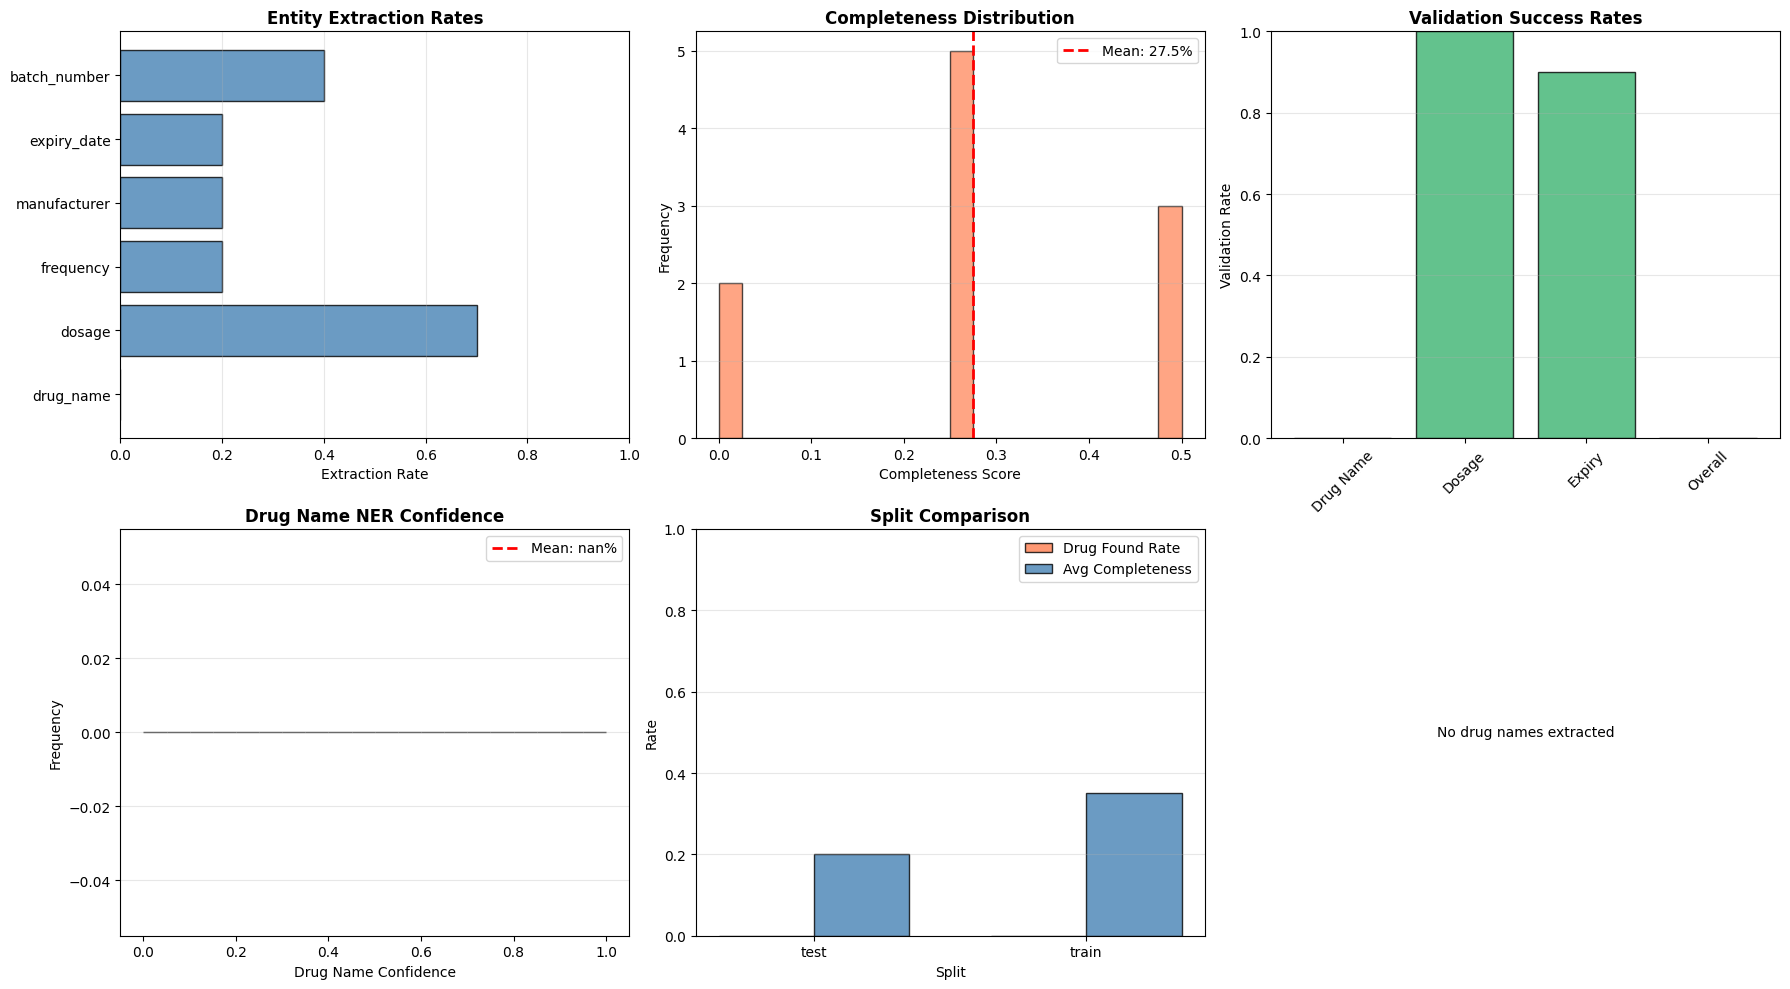


✅ NER results visualization saved to 'ner_extraction_results.png'

📋 Sample Extraction Results:

✅ Step 15 Complete:  Batch NER processing finished


In [ ]:
# ============================================================================
# Execute Batch NER Processing
# ============================================================================

print("\n⚠️  BATCH NER PROCESSING OPTIONS:")
print("="*70)
print("Option 1: Quick test (100 images) - ~5-10 minutes")
print("Option 2: Full processing (all images with successful OCR) - ~1-2 hours")
print("="*70)

QUICK_TEST = True  # Set to False for full processing

if QUICK_TEST:
    print("\n🚀 Running QUICK TEST (100 images)...")
    max_samples = 100
else:
    print("\n🚀 Running FULL PROCESSING...")
    max_samples = None

if ocr_results_df is not None:
    # Create processor
    ner_processor = BatchNERProcessor(combined_extractor, validator)

    # Process
    print("\n" + "="*70)
    print("STARTING BATCH NER PROCESSING")
    print("="*70)

    import time
    from datetime import timedelta # Import timedelta

    start_time = time.time()

    ner_results_df = ner_processor.process_ocr_results(
        ocr_results_df,
        max_samples=max_samples
    )

    total_time = time.time() - start_time

    # Save results
    output_file = 'ner_extraction_results.csv'
    ner_results_df.to_csv(output_file, index=False)

    print(f"\n💾 Results saved to: {output_file}")
    print(f"⏱️  Total time: {timedelta(seconds=int(total_time))}")

    # Generate report
    ner_processor. generate_report(ner_results_df)

    # Show sample results
    print("\n📋 Sample Extraction Results:")
    print("="*70)

    # Get 5 complete extractions
    complete_results = ner_results_df[ner_results_df['completeness_score'] > 0.75]. head(5)

    for idx, row in complete_results. iterrows():
        print(f"\n[{row['filename'][:40]}]")
        print(f"   Drug: {row['drug_name']} (conf: {row['drug_confidence']:.2f})")
        print(f"   Dosage: {row['dosage']}")
        print(f"   Frequency: {row['frequency']}")
        print(f"   Manufacturer: {row['manufacturer']}")
        print(f"   Completeness: {row['completeness_score']:.1%}")
        print(f"   Valid: {'✓' if row['overall_valid'] else '✗'}")

    print("\n✅ Step 15 Complete:  Batch NER processing finished")

else:
    print("\n⚠️  OCR results not found!  Load Phase 2 results first.")

**💾 Save Phase 3 to Google Drive**

In [ ]:
# ============================================================================
# SAVE PHASE 3 TO GOOGLE DRIVE
# ============================================================================

print("\n" + "="*70)
print(" " * 20 + "SAVING PHASE 3 TO GOOGLE DRIVE")
print("="*70)

import shutil # Added this line

# Create Phase 3 folder
phase3_drive_path = os.path.join(drive_project_path, "Phase3_NER")
os.makedirs(phase3_drive_path, exist_ok=True)

print(f"📂 Phase 3 folder:  {phase3_drive_path}")

# Files to save
phase3_files = [
    'ner_extraction_results.csv',
    'ner_extraction_results.png'
]

print("\n📄 Copying Phase 3 files...")
for file in phase3_files:
    if os.path.exists(file):
        shutil.copy2(file, phase3_drive_path)
        print(f"✅ Copied:  {file}")
    else:
        print(f"⚠️  Not found: {file}")

# Create summary
if ner_results_df is not None:
    phase3_summary = {
        'total_processed': len(ner_results_df),
        'drug_names_found': int(ner_results_df['drug_name']. notna().sum()),
        'drug_extraction_rate': float(ner_results_df['drug_name'].notna().mean()),
        'dosage_extraction_rate': float(ner_results_df['dosage'].notna().mean()),
        'avg_completeness':  float(ner_results_df['completeness_score'].mean()),
        'validation_success_rate': float(ner_results_df['overall_valid'].mean()),
        'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'quick_test':  QUICK_TEST
    }

    with open('phase3_summary.json', 'w') as f:
        json.dump(phase3_summary, f, indent=2)

    shutil.copy2('phase3_summary.json', phase3_drive_path)
    print(f"✅ Copied:  phase3_summary.json")

# Create README
phase3_readme = f"""
# MediScope OCR Project - Phase 3: NER COMPLETE

**Completed:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

## Steps Completed:
- ✅ Step 10: Setup Medical NER Model (BioBERT)
- ✅ Step 11: Extract Entities from OCR Text
- ✅ Step 12: Implement Regex Post-Processing
- ✅ Step 13: Combine NER + Regex Results
- ✅ Step 14: Add Validation Rules
- ✅ Step 15: Batch Process All OCR Results

## Final Results:
- **Images processed:** {len(ner_results_df) if ner_results_df is not None else 'N/A'}
- **Drug names found:** {phase3_summary['drug_extraction_rate']:.1%}
- **Dosage extraction:** {phase3_summary['dosage_extraction_rate']:.1%}
- **Avg completeness:** {phase3_summary['avg_completeness']:.1%}
- **Validation success:** {phase3_summary['validation_success_rate']:.1%}

## NER Models Used:
- **Primary:** BioBERT (alvaroalon2/biobert_diseases_ner)
- **Regex patterns:** Dosage, frequency, expiry, batch, manufacturer, storage

## Entities Extracted:
- Drug name (with confidence)
- Dosage
- Frequency
- Indication
- Manufacturer
- Batch number
- Expiry date
- Storage instructions

## Next Phase:
- **Phase 4:** Knowledge Base Integration
  - Build local drug database
  - Implement drug lookup
  - Add therapeutic information
  - API fallback (OpenFDA)

## Files:
- ner_extraction_results.csv: Complete extraction results
- ner_extraction_results.png: Visualization
- phase3_summary.json: Statistics
"""

readme_path = os.path.join(phase3_drive_path, "README_Phase3_COMPLETE.md")
with open(readme_path, 'w') as f:
    f.write(phase3_readme)

print(f"\n✅ README created")

print("\n" + "="*70)
print("🎉 PHASE 3 COMPLETE AND BACKED UP!")
print("="*70)
print(f"📁 Location: {phase3_drive_path}")
if ner_results_df is not None:
    print(f"📊 Drug extraction rate: {phase3_summary['drug_extraction_rate']:.1%}")
    print(f"🎯 Avg completeness: {phase3_summary['avg_completeness']:.1%}")
print("="*70)
print("\n✅ Ready for Phase 4: Knowledge Base Integration")
print("   Next:  Link extracted drug names to therapeutic information")


                    SAVING PHASE 3 TO GOOGLE DRIVE
📂 Phase 3 folder:  /content/drive/MyDrive/MediScope_OCR_Project/Phase3_NER

📄 Copying Phase 3 files...
✅ Copied:  ner_extraction_results.csv
✅ Copied:  ner_extraction_results.png
✅ Copied:  phase3_summary.json

✅ README created

🎉 PHASE 3 COMPLETE AND BACKED UP!
📁 Location: /content/drive/MyDrive/MediScope_OCR_Project/Phase3_NER
📊 Drug extraction rate: 0.0%
🎯 Avg completeness: 27.5%

✅ Ready for Phase 4: Knowledge Base Integration
   Next:  Link extracted drug names to therapeutic information
